In [2]:
!pip install pandas sodapy seaborn folium

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import time
from urllib.parse import urlencode

BASE_URL = "https://data.cityofchicago.org/resource/ijzp-q8t2.csv"

START = "2014-01-01T00:00:00"
END = "2025-12-31T23:59:59"

LIMIT = 50000
SLEEP_SEC = 0.3
MAX_PAGES = 1000

SELECT_COLS = ",".join(["id","case_number","date","block","iucr","primary_type","description","location_description","arrest", "domestic","beat", "district", "ward", "community_area","fbi_code","year","latitude", "longitude","location"
])

chunks = []
offset = 0

print("Start fetching pages...")

for page in range(MAX_PAGES):
    params = {
    "$select": SELECT_COLS,
    "$where": f"date between '{START}' and '{END}'",
    "$order": "date",
    "$limit": LIMIT,
    "$offset": offset}

    url = BASE_URL + "?" + urlencode(params)

    df_part = pd.read_csv(url)

    if df_part.empty:
        print(f"Stop: page {page+1} is empty. Done.")
        break

    chunks.append(df_part)
    offset += LIMIT

    print(f"Page {page+1}: rows={len(df_part)}, next_offset={offset}")
    time.sleep(SLEEP_SEC)
    
df = pd.concat(chunks, ignore_index=True)
df["date"] = pd.to_datetime(df["date"], errors="coerce")

print("Final shape:", df.shape)


Start fetching pages...
Page 1: rows=50000, next_offset=50000
Page 2: rows=50000, next_offset=100000
Page 3: rows=50000, next_offset=150000
Page 4: rows=50000, next_offset=200000
Page 5: rows=50000, next_offset=250000
Page 6: rows=50000, next_offset=300000
Page 7: rows=50000, next_offset=350000
Page 8: rows=50000, next_offset=400000
Page 9: rows=50000, next_offset=450000
Page 10: rows=50000, next_offset=500000
Page 11: rows=50000, next_offset=550000
Page 12: rows=50000, next_offset=600000
Page 13: rows=50000, next_offset=650000
Page 14: rows=50000, next_offset=700000
Page 15: rows=50000, next_offset=750000
Page 16: rows=50000, next_offset=800000
Page 17: rows=50000, next_offset=850000
Page 18: rows=50000, next_offset=900000
Page 19: rows=50000, next_offset=950000
Page 20: rows=50000, next_offset=1000000
Page 21: rows=50000, next_offset=1050000
Page 22: rows=50000, next_offset=1100000
Page 23: rows=50000, next_offset=1150000
Page 24: rows=50000, next_offset=1200000
Page 25: rows=50000, 

In [5]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")

out_path = "/chicago_crime_2014_2025_raw.csv"
df.to_csv(out_path, index=False)
print("Saved:", out_path)

display(df.head(3))
# show how many missing data in each column
display(df.isna().mean().sort_values(ascending=False).head(10))

Saved: /chicago_crime_2014_2025_raw.csv


id case_number       date                 block  iucr  \
0  13434326    JH231444 2014-01-01       028XX W 23RD PL  0266   
1  13106144    JG300179 2014-01-01     030XX S DRAKE AVE  1752   
2  13360296    JH142462 2014-01-01  072XX S CARPENTER ST  1563   

                 primary_type  \
0     CRIMINAL SEXUAL ASSAULT   
1  OFFENSE INVOLVING CHILDREN   
2                 SEX OFFENSE   

                                         description location_description  \
0                                          PREDATORY      DAY CARE CENTER   
1  AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER            APARTMENT   
2                              CRIMINAL SEXUAL ABUSE            RESIDENCE   

   arrest  domestic  beat  district  ward  community_area fbi_code  year  \
0   False     False  1033      10.0  24.0            30.0       02  2014   
1    True     False  1032      10.0  22.0            30.0       17  2014   
2   False      True   733       7.0  17.0            68.0       17  2014   

   latitude  longitude location  
0       NaN        NaN      NaN  
1       NaN        NaN      NaN  
2       NaN        NaN      NaN

location                1.466251e-02
longitude               1.466251e-02
latitude                1.466251e-02
location_description    4.643305e-03
community_area          6.695964e-05
ward                    1.913133e-05
district                3.298504e-07
beat                    0.000000e+00
year                    0.000000e+00
fbi_code                0.000000e+00
dtype: float64

In [7]:
# create datatime type
df["year_from_date"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["hour"] = df["date"].dt.hour
df["weekday"] = df["date"].dt.day_name()
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df["weekday"] = pd.Categorical(df["weekday"], categories=order, ordered=True)

## **Temporal Analysis**

In [10]:
crimes_by_year = df.groupby("year_from_date").size()
print(crimes_by_year.head())

crimes_by_hour = df.groupby("hour").size()
print(crimes_by_hour.head())

crimes_by_weekday = df.groupby("weekday").size()
print(crimes_by_weekday)


year_from_date
2014    275883
2015    264887
2016    269956
2017    269283
2018    269142
dtype: int64
hour
0    182097
1     94490
2     82289
3     69095
4     55124
dtype: int64
weekday
Monday       431896
Tuesday      425744
Wednesday    429341
Thursday     425822
Friday       450435
Saturday     440558
Sunday       427881
dtype: int64


C:\Users\Yizhuo Zhang\AppData\Local\Temp\ipykernel_4932\1382403095.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crimes_by_weekday = df.groupby("weekday").size()


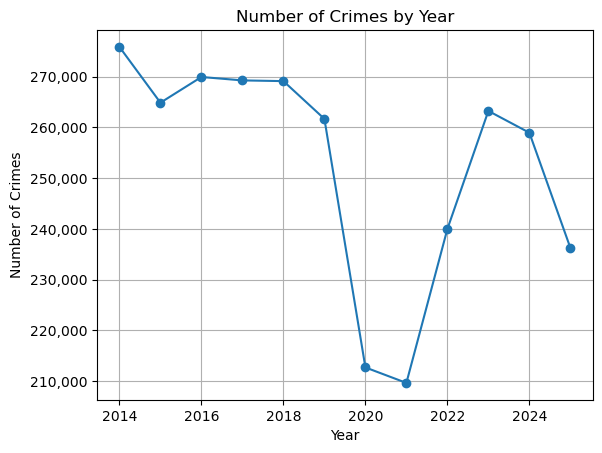

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: f"{int(x):,}")
)
crimes_by_year.plot(kind="line", marker="o")
plt.title("Number of Crimes by Year")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.grid(True)
plt.show()


### **Yearly Trend**
The annual number of reported crimes remains relatively stable from 2016 to 2018, at around 270,000 cases per year. A sharp decline is observed in 2020, continuing into 2021, which coincides with the COVID-19 pandemic period. From 2022 onward, crime counts increase substantially, indicating a strong post-pandemic rebound. However, after peaking around 2023, the trend shows a moderate decline in 2024 and 2025.

Overall, this pattern suggests that the COVID-19 pandemic acted as a major external shock to crime activity and reporting. While crime levels rebounded as mobility and social activities resumed, the more recent decline in 2024–2025 indicates a potential stabilization phase rather than a full return to the pre-pandemic peak.


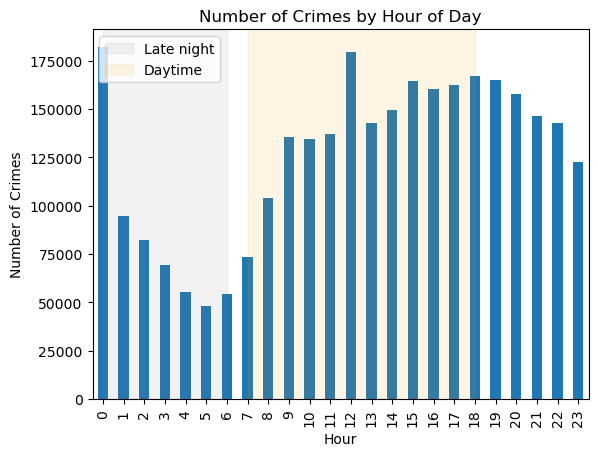

In [14]:
crimes_by_hour.plot(kind="bar")
plt.title("Number of Crimes by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Crimes")
plt.axvspan(0, 6, alpha=0.1, color="gray", label="Late night")
plt.axvspan(7, 18, alpha=0.1, color="orange", label="Daytime")
plt.legend()
plt.show()

### **Hourly Distribution**
The hourly distribution of crimes exhibits a clear and consistent daily cycle. Crime counts are highest around midnight (00:00), followed by a steady decline during the early morning hours, reaching a minimum between approximately 4:00 and 6:00. From 7:00 onward, reported crimes increase rapidly throughout the morning, with a pronounced peak around midday. Crime levels remain elevated during the afternoon and early evening hours (approximately 15:00–20:00) before gradually decreasing later at night.

This pattern likely reflects variations in daily human activity and exposure across time. The elevated crime level around midnight may be associated with late-night social activities, alcohol-related interactions, and reduced guardianship, while the midday peak may correspond to increased population density, commuting, and routine commercial activities. In contrast, reduced activity and limited public presence during early morning hours are consistent with lower reported crime levels.

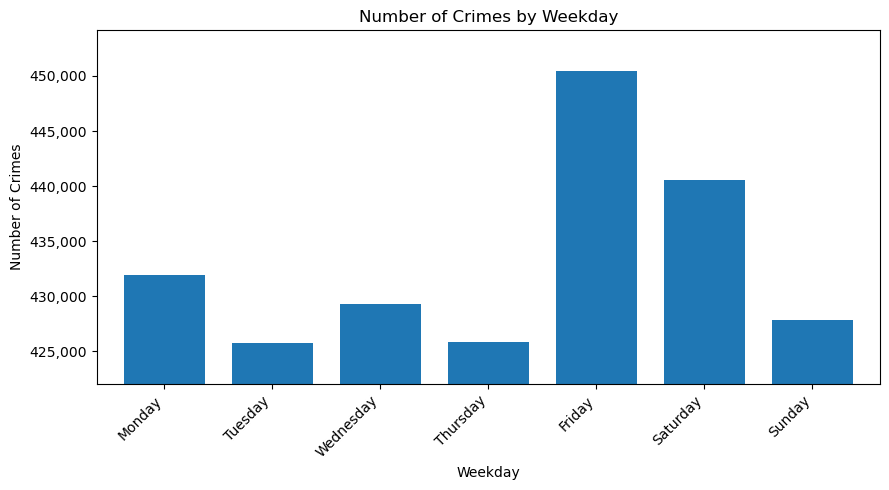

In [18]:
ax = crimes_by_weekday.plot(kind="bar", figsize=(9, 5), width=0.75)
ax.set_title("Number of Crimes by Weekday")
ax.set_xlabel("Weekday")
ax.set_ylabel("Number of Crimes")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

y_min = crimes_by_weekday.min()
y_max = crimes_by_weekday.max()
pad = (y_max - y_min) * 0.15
ax.set_ylim(y_min - pad, y_max + pad)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### **Weekday Pattern**
Crime counts remain relatively stable from Tuesday to Thursday, indicating no strong variation during the midweek period. Monday shows a slightly higher level of reported crimes compared with other midweek days, while a clear increase is observed toward the end of the week. Friday records the highest number of crimes, followed by Saturday, suggesting elevated crime activity during late-week and weekend periods. Sunday exhibits a moderate level, lower than Friday and Saturday but higher than most midweek days.

This pattern may reflect changes in routine activities across the week. Increased social, commercial, and recreational activities toward the end of the week and during weekends could contribute to higher crime exposure and reporting opportunities, while more regular weekday schedules from Tuesday to Thursday are associated with relatively stable crime levels.

## **Spatial Distribution**

In [22]:
import folium
from folium.plugins import HeatMap
# Crime density heatmap
df_geo = df.dropna(subset=["latitude", "longitude"])
df_sample = df_geo.sample(n=100000, random_state=42)
m = folium.Map(
    location=[41.88, -87.63],
    zoom_start=10,
    tiles="cartodbpositron"
)
HeatMap(
    data=df_sample[["latitude", "longitude"]].values,
    radius=8,
    blur=12,
    max_zoom=12
).add_to(m)

m


### **Crime density distribution**
The spatial heatmap reveals a clear clustering of crime incidents within the city of Chicago, with substantially lower densities observed near the city boundaries and surrounding suburban areas. This pattern suggests that crime is strongly concentrated in the urban core, likely reflecting higher population density and activity intensity.

Medium-density regions appear in distinct block-like patterns rather than being uniformly distributed, indicating spatial clustering of crime activity. These clusters may be shaped by neighborhood boundaries, road networks, and land-use structures. Several localized high-density hotspots are observed within central areas

High-density crime hotspots are primarily concentrated in the central and near-lake areas of Chicago, corresponding to regions with higher population density and urban activity intensity.Several prominent hotspots appear in the downtown and near North Side regions as well as parts of the South Side

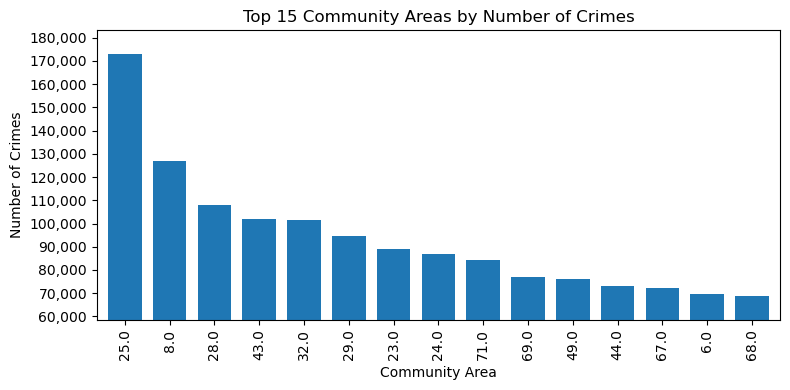

In [24]:
from matplotlib.ticker import MultipleLocator, FuncFormatter
# top 15 community areas
crimes_by_community = (
    df.groupby("community_area")
      .size()
      .sort_values(ascending=False)
)

top15 = crimes_by_community.head(15)

ax = top15.plot(
    kind="bar",
    figsize=(8, 4),
    width=0.75
)

ax.set_title("Top 15 Community Areas by Number of Crimes")
ax.set_xlabel("Community Area")
ax.set_ylabel("Number of Crimes")

y_min = top15.min()
y_max = top15.max()
pad = (y_max - y_min) * 0.1
ax.set_ylim(y_min - pad, y_max + pad)

ax.yaxis.set_major_locator(MultipleLocator(10000))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

plt.tight_layout()
plt.show()

### **Community distribution**
The bar chart of the top 15 community areas reveals a pronounced spatial concentration of crime incidents. One community area exhibits a substantially higher number of reported crimes than all others, indicating a dominant hotspot at the community level. Beyond this leading area, crime counts decline gradually across the remaining high-crime communities, forming a clear ranking structure rather than a uniform distribution.

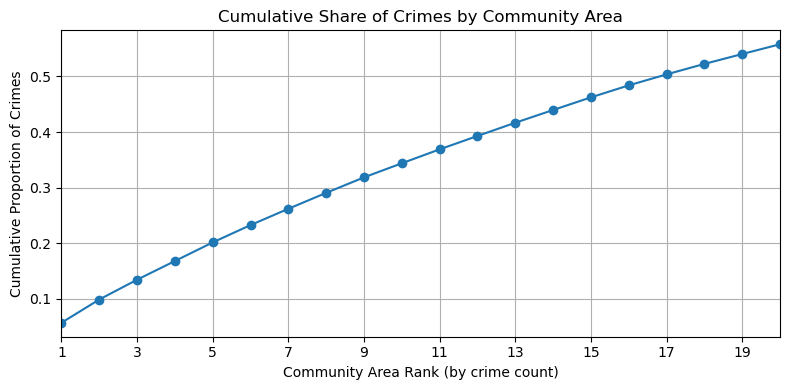

In [26]:
counts = crimes_by_community.sort_values(ascending=False)
cum_share = counts.cumsum() / counts.sum()
rank = range(1, len(cum_share) + 1)
plt.figure(figsize=(8, 4))
plt.plot(rank[:20], cum_share.iloc[:20], marker="o")

plt.xticks(range(1, 21, 2))
plt.xlim(1, 20)

plt.title("Cumulative Share of Crimes by Community Area")
plt.xlabel("Community Area Rank (by crime count)")
plt.ylabel("Cumulative Proportion of Crimes")
plt.grid(True)
plt.tight_layout()
plt.show()



### **Cumulative distribution by Community**
The cumulative distribution of crimes by community area rank reveals a pronounced spatial concentration of crime incidents.Approximately half of all reported crimes are contributed by the top 17 ranked community areas.While the bar chart highlights individual high-crime communities, the cumulative distribution further demonstrates that a relatively small subset of communities accounts for a disproportionately large share of total crime incidents.

## Plots for report

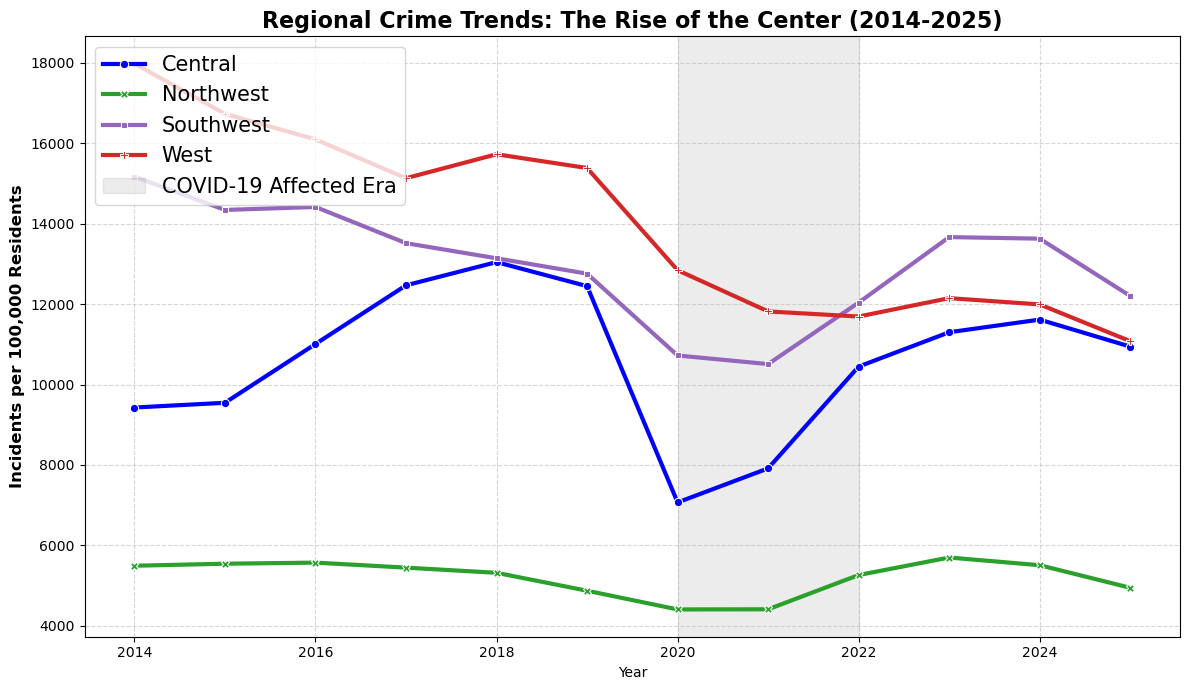

Plot Generated: crime_trend_west_sw_central_nw.png


In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


district_groups = {
    1.0: 'Central', 18.0: 'Central',
    11.0: 'West', 15.0: 'West',
    8.0: 'Southwest', 9.0: 'Southwest',
    16.0: 'Northwest', 17.0: 'Northwest'
}


district_pops = {
    1.0: 70000,   18.0: 175000, 
    11.0: 91000,  15.0: 96000, 
    8.0: 110000,  9.0: 100000,  
    16.0: 170000, 17.0: 140000 
}


target_districts = list(district_groups.keys())
df_subset = df[df['district'].isin(target_districts)].copy()


dist_counts = df_subset.groupby(['year', 'district']).size().reset_index(name='incidents')


dist_counts['Region'] = dist_counts['district'].map(district_groups)
dist_counts['Population'] = dist_counts['district'].map(district_pops)

region_trends = dist_counts.groupby(['year', 'Region'])[['incidents', 'Population']].sum().reset_index()

region_trends['Crime_Rate'] = (region_trends['incidents'] / region_trends['Population']) * 100000

plt.figure(figsize=(12, 7))

colors = {
    'Central': 'blue',       
    'West': '#d62728',       
    'Southwest': '#9467bd',  
    'Northwest': '#2ca02c'  
}

sns.lineplot(
    data=region_trends,
    x='year',
    y='Crime_Rate',
    hue='Region',
    style='Region',
    markers=True,
    dashes=False,
    linewidth=3,
    palette=colors
)

plt.title('Regional Crime Trends: The Rise of the Center (2014-2025)', fontsize=16, fontweight='bold')
plt.ylabel('Incidents per 100,000 Residents', fontsize=12, fontweight='bold')
plt.xlabel('Year')
plt.grid(True, linestyle='--', alpha=0.5)

plt.axvspan(2020, 2022, color='gray', alpha=0.15, label='COVID-19 Affected Era')

plt.legend(loc='upper left', fontsize=15)
plt.tight_layout()

plt.savefig('crime_trend_west_sw_central_nw.png', dpi=300)
plt.show()

print("Plot Generated: crime_trend_west_sw_central_nw.png")

C:\Users\Yizhuo Zhang\AppData\Local\Temp\ipykernel_4932\2923296001.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_crimes = crime_counts.groupby('Region').apply(lambda x: x.nlargest(5, 'Percent')).reset_index(drop=True)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` var

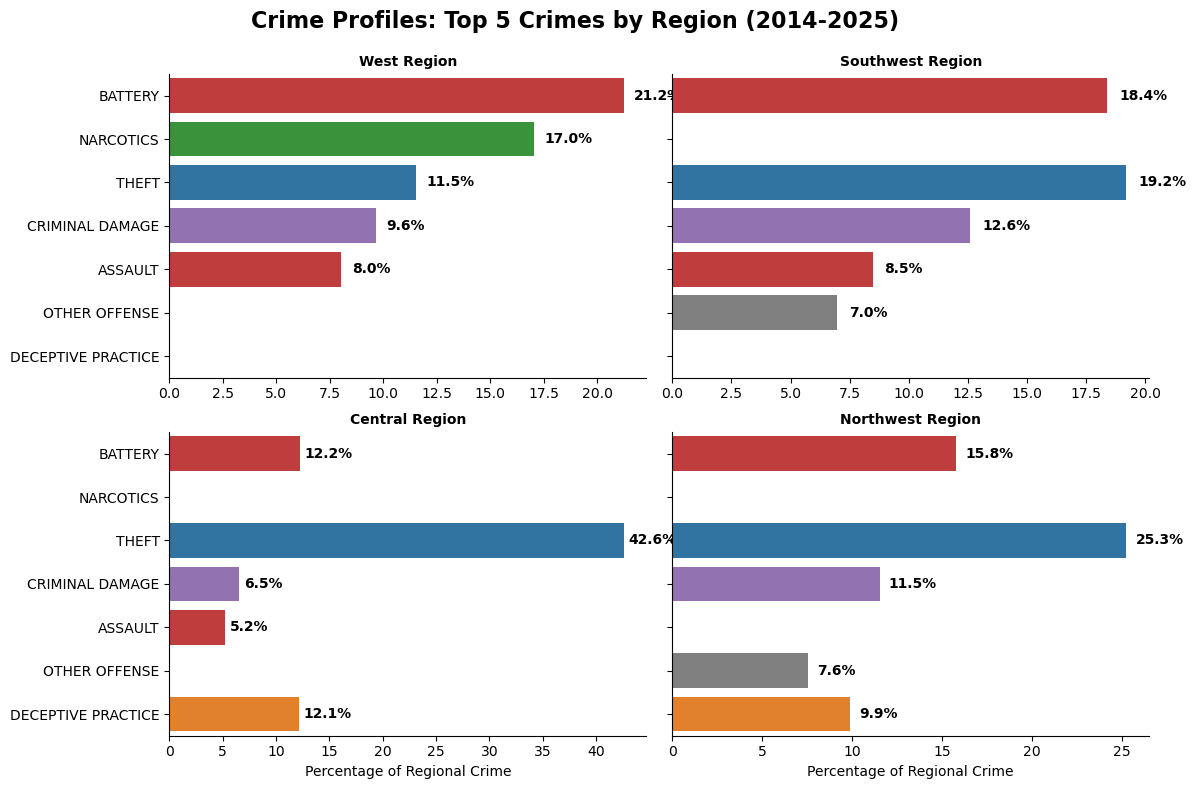

Plot Generated: crime_profiles_west_sw_central_nw.png


In [31]:


region_map = {
    1.0: 'Central', 18.0: 'Central',
    11.0: 'West', 15.0: 'West',
    8.0: 'Southwest', 9.0: 'Southwest',
    16.0: 'Northwest', 17.0: 'Northwest'
}

df_region = df[
    (df['district'].isin(region_map.keys())) & 
    (df['year'] >= 2014)
].copy()


df_region['Region'] = df_region['district'].map(region_map)

crime_counts = df_region.groupby(['Region', 'primary_type']).size().reset_index(name='Count')

crime_counts['Total_Region'] = crime_counts.groupby('Region')['Count'].transform('sum')
crime_counts['Percent'] = (crime_counts['Count'] / crime_counts['Total_Region']) * 100

top_crimes = crime_counts.groupby('Region').apply(lambda x: x.nlargest(5, 'Percent')).reset_index(drop=True)

g = sns.FacetGrid(top_crimes, col="Region", col_wrap=2, height=4, aspect=1.5, sharex=False, 
                  col_order=['West', 'Southwest', 'Central', 'Northwest'])

def get_color(crime_type):
    ct = crime_type.upper()
    if 'THEFT' in ct or 'BURGLARY' in ct or 'ROBBERY' in ct: return '#1f77b4' 
    if 'BATTERY' in ct or 'ASSAULT' in ct: return '#d62728' 
    if 'DECEPTIVE' in ct: return '#ff7f0e'
    if 'NARCOTICS' in ct or 'WEAPONS' in ct: return '#2ca02c'
    if 'CRIMINAL DAMAGE' in ct: return '#9467bd' 
    return 'gray'


palette_dict = {crime: get_color(crime) for crime in top_crimes['primary_type'].unique()}

g.map_dataframe(sns.barplot, x="Percent", y="primary_type", palette=palette_dict)

# Titles and Labels
g.set_titles("{col_name} Region", fontweight='bold', fontsize=14)
g.set_axis_labels("Percentage of Regional Crime", "")

for ax in g.axes.flat:
    for p in ax.patches:
        width = p.get_width()
        if width > 0: # Only label if bar exists
            ax.text(width + 0.5, p.get_y() + p.get_height()/2, 
                    f'{width:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Crime Profiles: Top 5 Crimes by Region (2014-2025)', fontsize=16, fontweight='bold')

plt.savefig('crime_profiles_west_sw_central_nw.png', dpi=300)
plt.show()

print("Plot Generated: crime_profiles_west_sw_central_nw.png")

Aggregating Crime Data by District...


C:\Users\Yizhuo Zhang\AppData\Local\Temp\ipykernel_4932\3129646264.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Label', data=district_counts, palette='Reds_r')


Saved: top_10_dangerous_districts_labeled.png


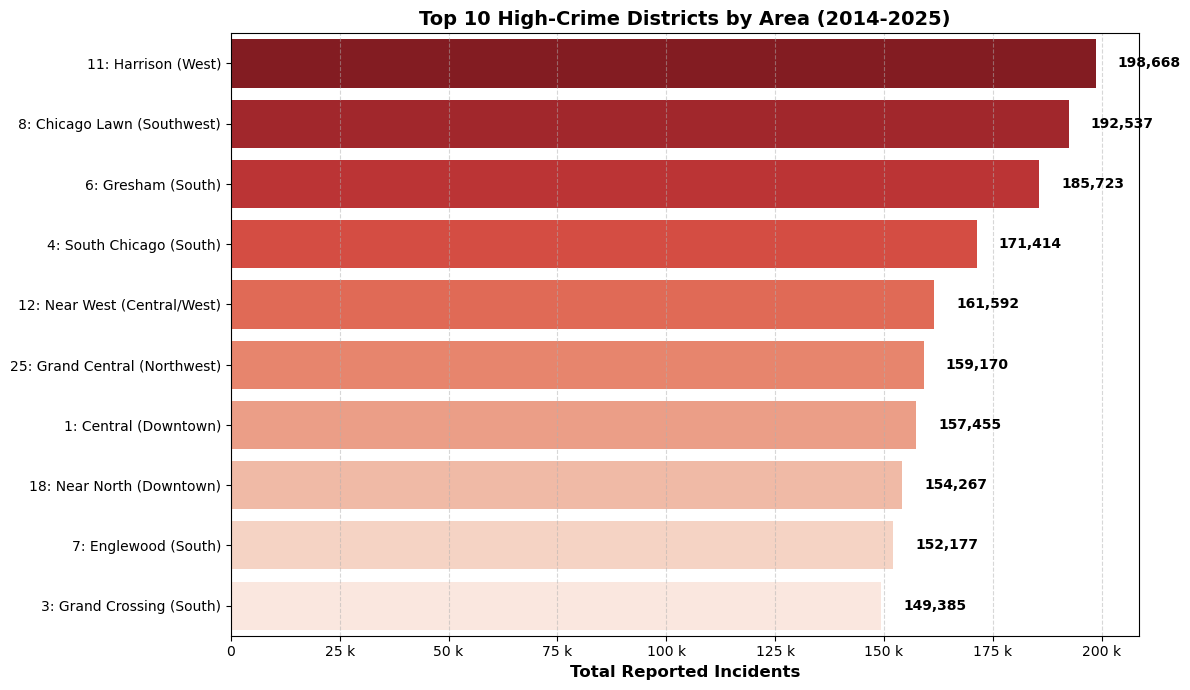

In [32]:

import matplotlib.ticker as ticker


district_map = {
    1.0: '1: Central (Downtown)',
    2.0: '2: Wentworth (South)',
    3.0: '3: Grand Crossing (South)',
    4.0: '4: South Chicago (South)',
    5.0: '5: Calumet (South)',
    6.0: '6: Gresham (South)',
    7.0: '7: Englewood (South)',
    8.0: '8: Chicago Lawn (Southwest)',
    9.0: '9: Deering (South)',
    10.0: '10: Ogden (West)',
    11.0: '11: Harrison (West)',
    12.0: '12: Near West (Central/West)',
    14.0: '14: Shakespeare (Northwest)',
    15.0: '15: Austin (Far West)',
    16.0: '16: Jefferson Park (Northwest)',
    17.0: '17: Albany Park (Northwest)',
    18.0: '18: Near North (Downtown)',
    19.0: '19: Town Hall (North)',
    20.0: '20: Lincoln (North)',
    22.0: '22: Morgan Park (Far South)',
    24.0: '24: Rogers Park (Far North)',
    25.0: '25: Grand Central (Northwest)'
}



print("Aggregating Crime Data by District...")

df_dist = df[(df['date'].dt.year >= 2014) & (df['date'].dt.year <= 2025)].copy()


df_dist['district'] = pd.to_numeric(df_dist['district'], errors='coerce')

district_counts = df_dist['district'].value_counts().nlargest(10).reset_index()
district_counts.columns = ['District_ID', 'Count']

district_counts['Label'] = district_counts['District_ID'].map(district_map)

district_counts['Label'] = district_counts['Label'].fillna(district_counts['District_ID'].astype(str))

plt.figure(figsize=(12, 7))


ax = sns.barplot(x='Count', y='Label', data=district_counts, palette='Reds_r')


for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(
        width + 5000,  
        p.get_y() + p.get_height()/2, 
        f'{int(width):,}', 
        va='center', 
        fontsize=10, 
        fontweight='bold',
        color='black'
    )


ax.xaxis.set_major_formatter(ticker.EngFormatter())
plt.title('Top 10 High-Crime Districts by Area (2014-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Total Reported Incidents', fontsize=12, fontweight='bold')
plt.ylabel('', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig('top_10_dangerous_districts_labeled.png', dpi=300)
print("Saved: top_10_dangerous_districts_labeled.png")
plt.show()

Generating Fig 1: Composition...


C:\Users\Yizhuo Zhang\AppData\Local\Temp\ipykernel_4932\1442948279.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Crime Type', data=top_crimes, palette='viridis')


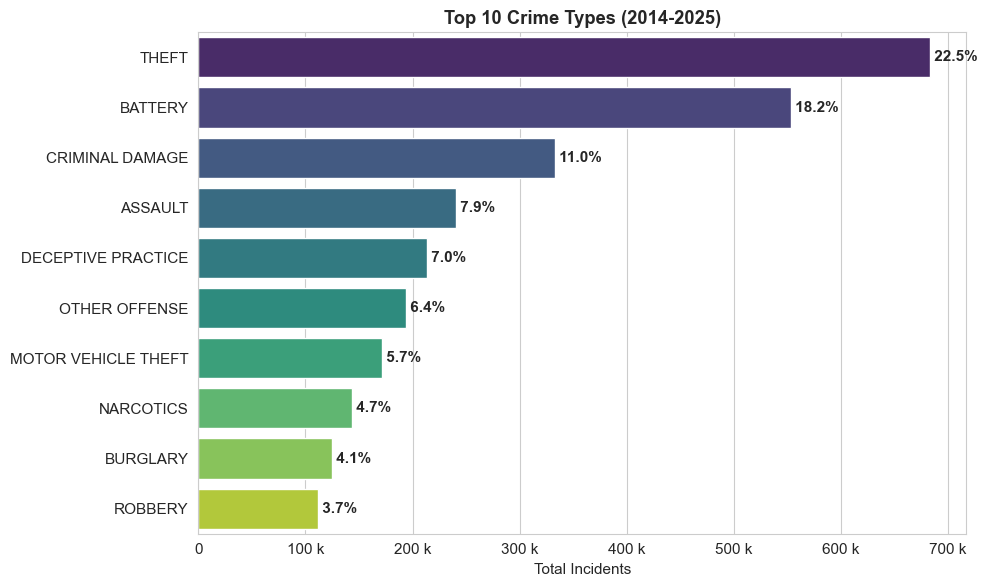

In [35]:


df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['day_name'] = df['date'].dt.day_name()

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11, 'font.family': 'sans-serif'})


print("Generating Fig 1: Composition...")
plt.figure(figsize=(10, 6))


type_col = 'primary_type' if 'primary_type' in df.columns else 'primary_description'

top_crimes = df[type_col].value_counts().nlargest(10).reset_index()
top_crimes.columns = ['Crime Type', 'Count']
top_crimes['Percent'] = (top_crimes['Count'] / len(df)) * 100

ax = sns.barplot(x='Count', y='Crime Type', data=top_crimes, palette='viridis')

for i, p in enumerate(ax.patches):
    width = p.get_width()
    pct = f"{top_crimes.iloc[i]['Percent']:.1f}%"
    ax.text(width, p.get_y() + p.get_height()/2, f" {pct}", va='center', fontweight='bold')

ax.xaxis.set_major_formatter(ticker.EngFormatter())
plt.title('Top 10 Crime Types (2014-2025)', fontweight='bold')
plt.xlabel('Total Incidents')
plt.ylabel('')
plt.tight_layout()
plt.savefig('crime_composition_overview.png', dpi=300)
plt.show()





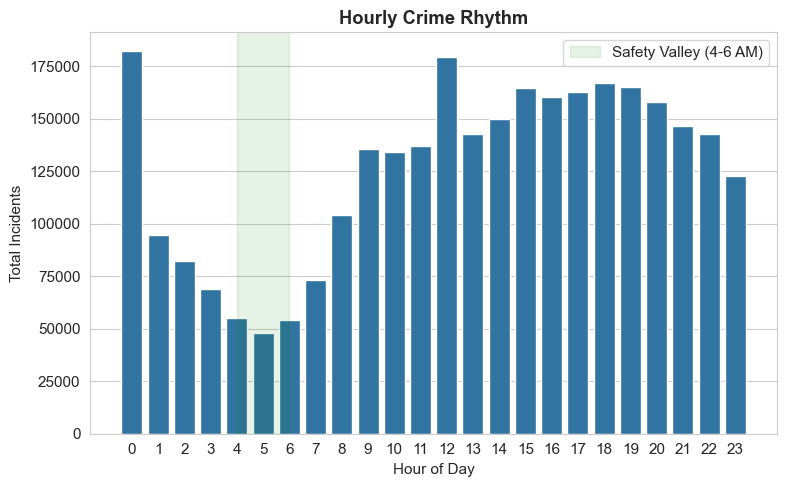

In [36]:

plt.figure(figsize=(8, 5))
hourly_counts = df['hour'].value_counts().sort_index()

sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color='#1f77b4')


plt.axvspan(4, 6, color='green', alpha=0.1, label='Safety Valley (4-6 AM)')
plt.title('Hourly Crime Rhythm', fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Total Incidents')
plt.legend()
plt.tight_layout()
plt.savefig('crime_hourly_distribution.png', dpi=300)
plt.show()

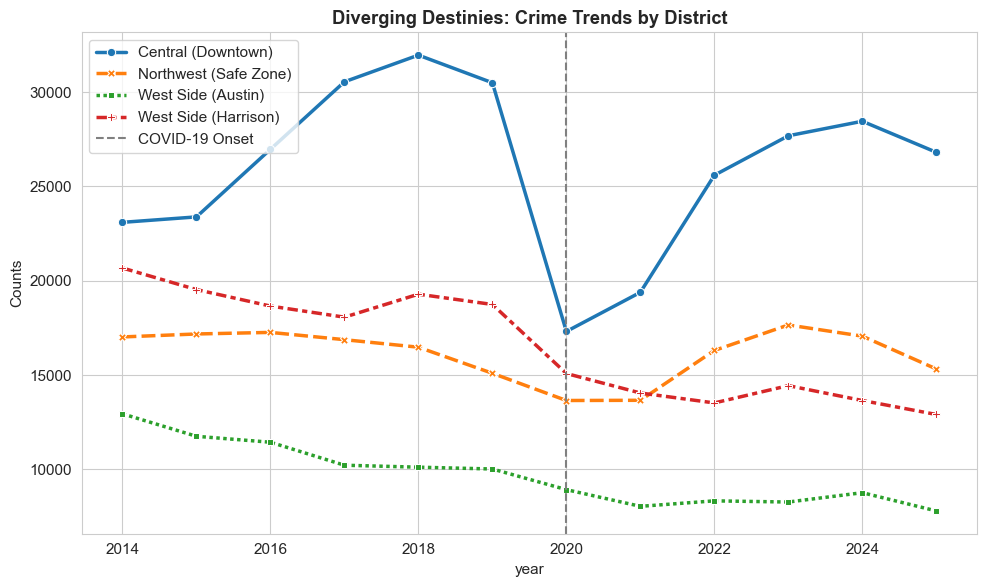

In [40]:
plt.figure(figsize=(10, 6))

# Ensure district is numeric
df['district'] = pd.to_numeric(df['district'], errors='coerce')

archetypes = {
    1.0: 'Central (Downtown)', 18.0: 'Central (Downtown)',
    11.0: 'West Side (Harrison)', 15.0: 'West Side (Austin)',
    16.0: 'Northwest (Safe Zone)', 17.0: 'Northwest (Safe Zone)'
}

df_trend = df[df['district'].isin(archetypes.keys())].copy()
df_trend['Region'] = df_trend['district'].map(archetypes)
trend_data = df_trend.groupby(['year', 'Region']).size().reset_index(name='Counts')

sns.lineplot(data=trend_data, x='year', y='Counts', hue='Region', style='Region', markers=True, linewidth=2.5)

plt.axvline(2020, color='gray', linestyle='--', label='COVID-19 Onset')
plt.title('Diverging Destinies: Crime Trends by District', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('crime_trend_districts.jpg', dpi=300)

plt.show()

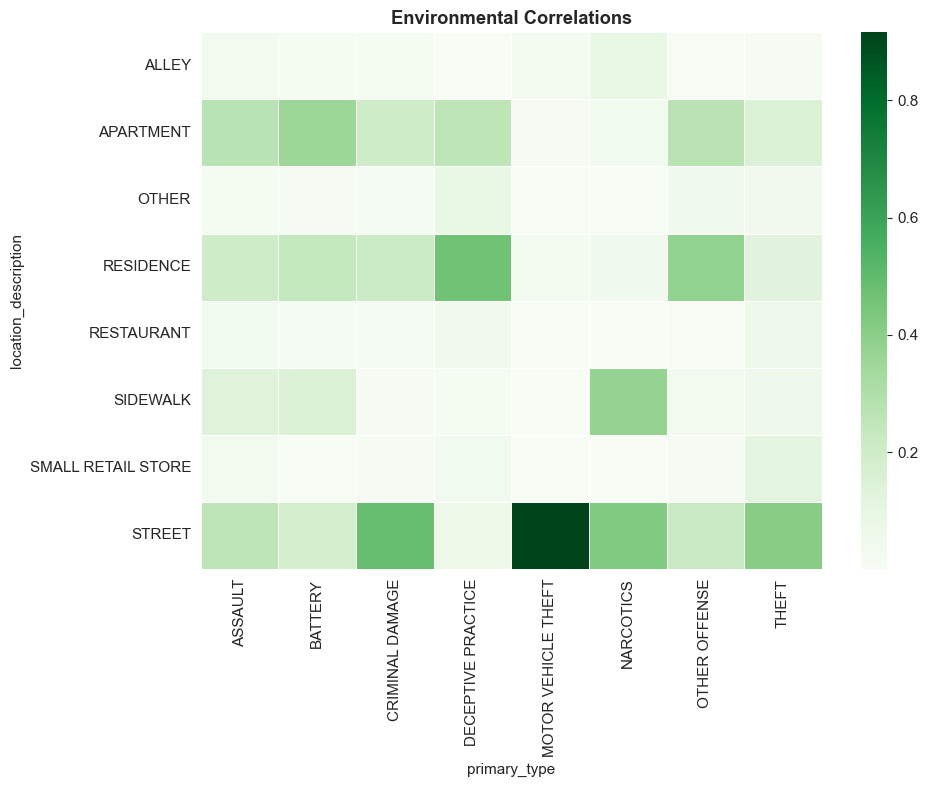

In [42]:
plt.figure(figsize=(10, 8))

top_types = top_crimes['Crime Type'].head(8).tolist()
top_locs = df['location_description'].value_counts().head(8).index
df_mx = df[(df[type_col].isin(top_types)) & (df['location_description'].isin(top_locs))]

matrix = pd.crosstab(df_mx['location_description'], df_mx[type_col])
matrix_norm = matrix.div(matrix.sum(axis=0), axis=1)

sns.heatmap(matrix_norm, cmap='Greens', annot=False, linewidths=0.5)
plt.title('Environmental Correlations', fontweight='bold')
plt.tight_layout()
plt.savefig('crime_location_correlation.png', dpi=300)


plt.show()

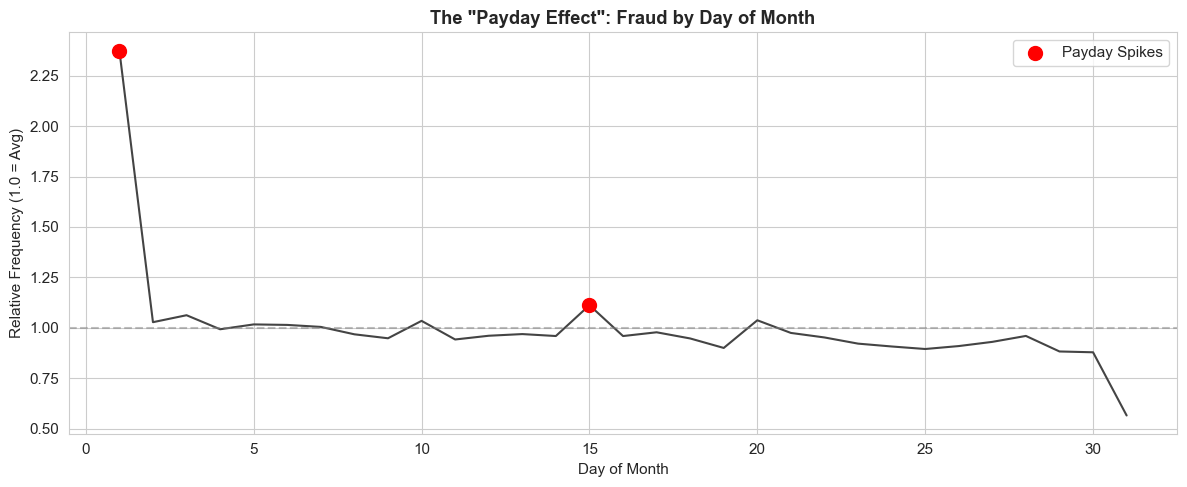

In [46]:
plt.figure(figsize=(12, 5))

# Filter for Fraud
fraud = df[df['primary_type'].str.contains('DECEPTIVE', na=False)]

daily_counts = fraud.groupby('day').size()
# Normalize to daily average
daily_norm = daily_counts / daily_counts.mean()

sns.lineplot(x=daily_norm.index, y=daily_norm.values, color='#444444')
plt.scatter([1, 15], daily_norm.loc[[1, 15]], color='red', s=100, zorder=5, label='Payday Spikes')
plt.axhline(1.0, linestyle='--', color='gray', alpha=0.5)

plt.title('The "Payday Effect": Fraud by Day of Month', fontweight='bold')
plt.xlabel('Day of Month')
plt.ylabel('Relative Frequency (1.0 = Avg)')
plt.legend()
plt.tight_layout()
plt.savefig('fraud_payday_effect.png', dpi=300)
plt.show()

## Heatmap Year Trend

Loading 'chicago_crime_2001_2024.csv'...
DEBUG: Dataset covers 2001 to 2024
Data looks good. Proceeding...

Final Data Distribution per Era (Should be balanced now):
Era
1. Early 2000s (2001-2006)       87342
2. Post-Recession (2007-2012)    88308
3. Recent Past (2013-2018)       87863
4. Modern Era (2019-2024)        88269
Name: count, dtype: int64
Rendering maps...


C:\Users\Yizhuo Zhang\AppData\Local\Temp\ipykernel_4932\3858172081.py:99: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_plot = df_hist.groupby('Era', group_keys=False).apply(


Saving to chicago_crime_history_full.png...


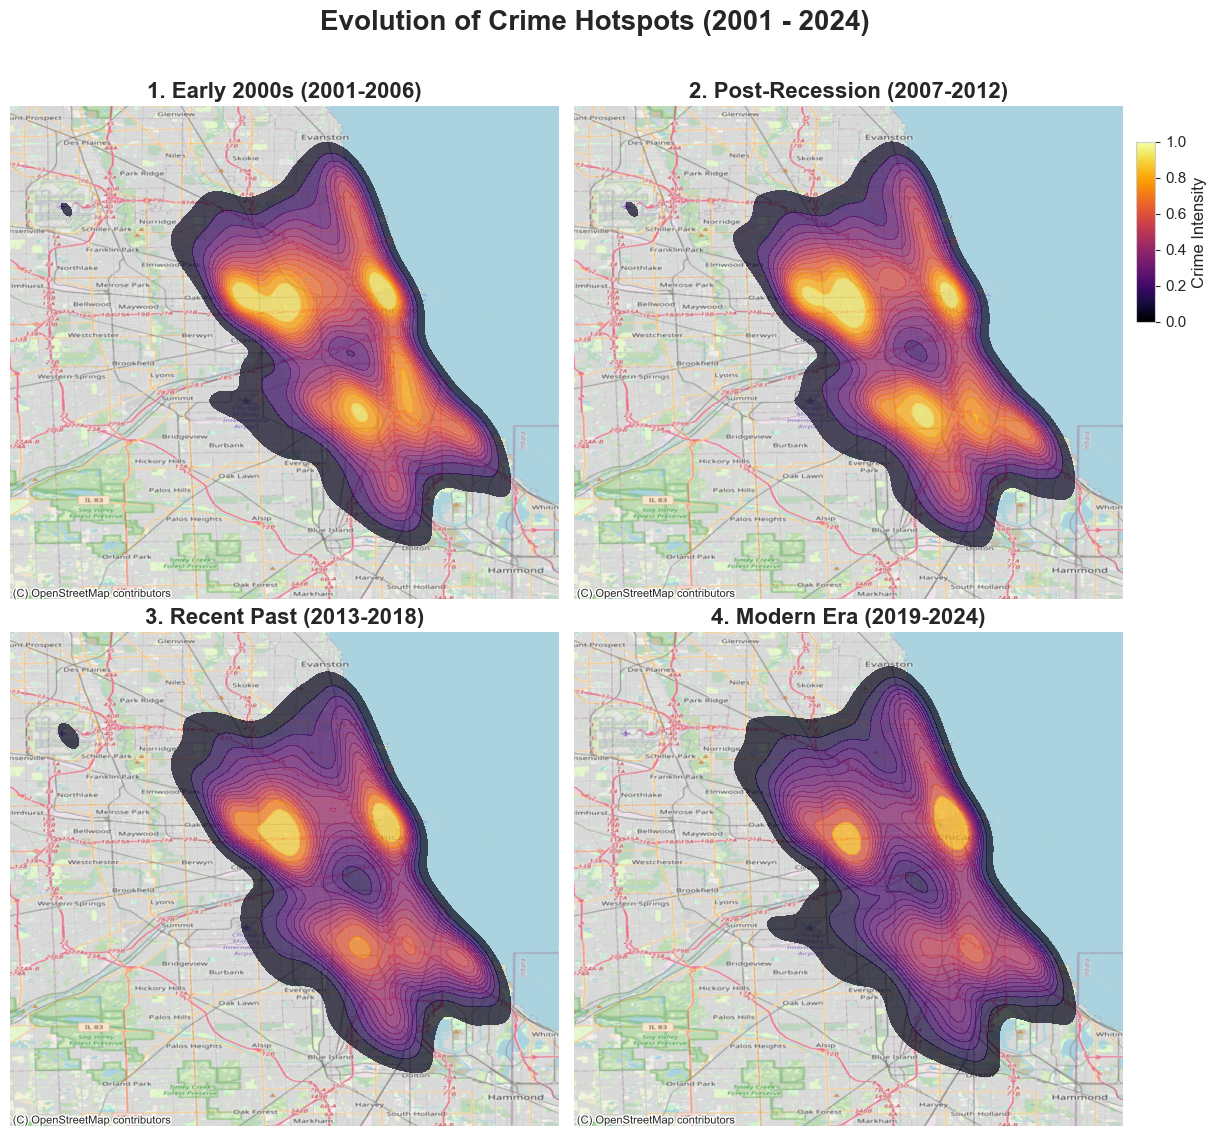

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib as mpl
import os
from urllib.parse import urlencode


FILENAME = "chicago_crime_2001_2024.csv"
BASE_URL = "https://data.cityofchicago.org/resource/ijzp-q8t2.csv"
NEEDS_DOWNLOAD = False

if os.path.exists(FILENAME):
    print(f"Loading '{FILENAME}'...")
    df = pd.read_csv(FILENAME)
    
   
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df['year'] = df['date'].dt.year
        
    min_year = df['year'].min()
    max_year = df['year'].max()
    print(f"DEBUG: Dataset covers {min_year} to {max_year}")
    
  
    if min_year > 2002:
        print("ALERT: Found incomplete data (missing early years). Deleting and re-fetching...")
        os.remove(FILENAME) 
        NEEDS_DOWNLOAD = True
    else:
        print("Data looks good. Proceeding...")

else:
    NEEDS_DOWNLOAD = True


if NEEDS_DOWNLOAD:
    print("Starting balanced download (Fetching samples from EACH year)...")
    chunks = []
    
   
    SELECT_COLS = "date,year,latitude,longitude"
    
    for yr in range(2001, 2025):
        print(f"  Fetching data for {yr}...", end="\r")
        params = {
            "$select": SELECT_COLS,
            "$where": f"year={yr}",
            "$limit": 15000,  # 15k rows per year = ~360k rows total (Perfect size)
            "$order": "date"
        }
        url = BASE_URL + "?" + urlencode(params)
        
        try:
            chunk = pd.read_csv(url)
            chunks.append(chunk)
        except Exception as e:
            print(f"  Error fetching {yr}: {e}")

    print("\nmerging and saving...")
    df = pd.concat(chunks, ignore_index=True)
    df.to_csv(FILENAME, index=False)
    print("Download Complete!")



if 'date' in df.columns and df['date'].dtype == 'O':
    df['date'] = pd.to_datetime(df['date'])
if 'year' not in df.columns:
    df['year'] = df['date'].dt.year

df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')


df_hist = df[
    (df['year'] >= 2001) & 
    (df['year'] <= 2024) & 
    (df['latitude'].notna())
].copy()

# Define Eras
def get_era(year):
    if 2001 <= year <= 2006: return '1. Early 2000s (2001-2006)'
    elif 2007 <= year <= 2012: return '2. Post-Recession (2007-2012)'
    elif 2013 <= year <= 2018: return '3. Recent Past (2013-2018)'
    elif 2019 <= year <= 2024: return '4. Modern Era (2019-2024)'
    return None

df_hist['Era'] = df_hist['year'].apply(get_era)
df_hist = df_hist.dropna(subset=['Era'])

print("\nFinal Data Distribution per Era (Should be balanced now):")
print(df_hist['Era'].value_counts().sort_index())


df_plot = df_hist.groupby('Era', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 10000), random_state=42)
)

print("Rendering maps...")
era_order = sorted(df_plot['Era'].unique())

g = sns.FacetGrid(
    df_plot, 
    col="Era", 
    col_wrap=2, 
    height=6, 
    aspect=1.1,
    col_order=era_order
)

g.map_dataframe(
    sns.kdeplot,
    x="longitude",
    y="latitude",
    fill=True,
    levels=15,
    thresh=0.05,    
    cmap="inferno", 
    alpha=0.7
)


for ax in g.axes.flat:
    try:
        ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    except: pass
    ax.set_axis_off()
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(1)

g.set_titles(col_template="{col_name}", size=16, fontweight='bold')


norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
sm.set_array([])
cbar_ax = g.fig.add_axes([0.91, 0.72, 0.015, 0.15]) 
g.fig.colorbar(sm, cax=cbar_ax).set_label('Crime Intensity', fontsize=12)

plt.subplots_adjust(top=0.9, right=0.9)
g.fig.suptitle('Evolution of Crime Hotspots (2001 - 2024)', fontsize=20, fontweight='bold')
# 5. SAVE BEFORE SHOWING
save_name = 'chicago_crime_history_full.png'
print(f"Saving to {save_name}...")
plt.savefig(save_name, dpi=300, bbox_inches='tight')
plt.show() 